In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in data
df_raw = pd.read_csv('https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD')

In [3]:
# Rename columns and remove unnecessary ones
df_raw.rename(
    columns= {
        'CAMIS':'ID',
        'DBA':'NAME',
        'ZIPCODE':'ZIP',
        'CUISINE DESCRIPTION':'CUISINE',
        'Latitude':'LAT',
        'Longitude':'LON'
    },
    inplace=True
)

df_raw.drop(['BUILDING', 'PHONE', 'RECORD DATE', 'BIN', 'BBL'], axis=1, inplace=True)

# Round off LAT/LON to use as feature
df_raw['LAT'] = df_raw['LAT'].round(2)
df_raw['LON'] = df_raw['LON'].round(2)


In [4]:
# Drop where boro = 0
df_raw = df_raw[df_raw['BORO'] != 0]

# # Drop pending grades (N, P, Z, G)
# df_raw = df_raw[~df_raw['GRADE'].isin(['N','P','Z','G'])]

# Convert date columns to datetime
df_raw[['INSPECTION DATE','GRADE DATE']] = df_raw[['INSPECTION DATE','GRADE DATE']].apply(pd.to_datetime)

# Get rid of restaurants that have never received a grade
graded = df_raw[df_raw['GRADE'].isin(['A','B','C'])]['ID'].drop_duplicates()
df_raw[df_raw['ID'].isin(graded)]
# df_raw = pd.merge(df_raw, df_raw[df_raw['GRADE'].isin(['A','B','C'])])

# Only look at re-inspections
df_raw = df_raw.query('`INSPECTION TYPE` == "Cycle Inspection / Re-inspection" ')

# Remove latest grade
mv = pd.merge(df_raw[['ID', 'GRADE DATE']], df_raw[df_raw['GRADE'].isin(['A','B','C'])].groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID', 'GRADE DATE']).rename(columns={'GRADE DATE':'mv'}).drop_duplicates()
df_raw = pd.merge(df_raw, mv, how='left', on='ID', suffixes=['','_mv'])
df_latest_review = df_raw.query('`GRADE DATE` == mv')[['ID','GRADE','mv']].drop_duplicates()
df_prev_reviews = df_raw.query('`GRADE DATE` != mv').drop_duplicates()

In [5]:
# Aggregate by restaurant to create features
n_inspections = df_prev_reviews.groupby('ID')['INSPECTION DATE'].nunique().rename('n_inspections')
avg_scores = df_prev_reviews.groupby(['ID', 'INSPECTION DATE'])['SCORE'].mean().reset_index().groupby('ID')['SCORE'].mean().rename('avg_score')
n_violations = df_prev_reviews.query('ACTION == "Violations were cited in the following area(s)."').groupby('ID')['ACTION'].count().rename('n_violations')
no_violation_inspection = df_prev_reviews.query('ACTION == "No violations were recorded at the time of this inspection."').groupby('ID')['ACTION'].count().rename('clean_inspections')
closed_by_DOHMH = df_prev_reviews.query('ACTION == "Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed."').groupby('ID')['ACTION'].count().rename('shutdowns')
reopened = df_prev_reviews.query('ACTION == "Establishment re-opened by DOHMH."').groupby('ID')['ACTION'].count().rename('reopened_count')
n_critical = df_prev_reviews.query('`CRITICAL FLAG` == "Critical" ').groupby('ID')['CRITICAL FLAG'].count().rename('n_critical_violations')

# #### THIS ONE LEADS TO GOOD RESULTS BUT SEEMS LESS CORRECT. IT RESULTS IN MULTIPLE ROWS FOR SOME IDs
# n_a_grade = df_prev_reviews.query('`GRADE` == "A" ').groupby(['ID', 'GRADE DATE'])['GRADE'].count().rename('n_A_grades')
# n_b_grade = df_prev_reviews.query('`GRADE` == "B" ').groupby(['ID', 'GRADE DATE'])['GRADE'].count().rename('n_B_grades')
# n_c_grade = df_prev_reviews.query('`GRADE` == "C" ').groupby(['ID', 'GRADE DATE'])['GRADE'].count().rename('n_C_grades')

#### THIS ONE LEADS TO BAD RESULTS BUT SEEMS MORE CORRECT. IT RESULTS IN 1 ROW PER ID
n_a_grade = df_prev_reviews.query('`GRADE` == "A" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_A_grades')
n_b_grade = df_prev_reviews.query('`GRADE` == "B" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_B_grades')
n_c_grade = df_prev_reviews.query('`GRADE` == "C" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_C_grades')


latest_grade = df_latest_review.groupby('ID')['GRADE'].max().rename('latest_grade')
first_grade = df_prev_reviews.merge(df_prev_reviews[df_prev_reviews['GRADE'].isin(['A','B','C'])].groupby('ID')['GRADE DATE'].min().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('first_grade')
penult_grade = pd.merge(df_prev_reviews, df_prev_reviews.groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('penult_grade')
# critical_violations_latest =
# critical_violations_first = 

dummies = pd.get_dummies(df_prev_reviews[['ID', 'VIOLATION CODE']])
dummy_sums = dummies.groupby('ID')[list(dummies.columns[1:])].sum()

# Merge together with categorical features
cat = df_raw[['ID','BORO','STREET','ZIP','CUISINE','LAT','LON','Community Board','Council District','Census Tract','NTA']].drop_duplicates()
# Merge features on ID
merged = pd.merge(cat, n_inspections, on='ID', how='left')\
    .merge(avg_scores, on='ID', how='left')\
    .merge(n_violations, on='ID', how='left')\
    .merge(no_violation_inspection, on='ID', how='left')\
    .merge(reopened, on='ID', how='left')\
    .merge(n_critical, on='ID', how='left')\
    .merge(n_a_grade, on='ID', how='left')\
    .merge(n_b_grade, on='ID', how='left')\
    .merge(n_c_grade, on='ID', how='left')\
    .merge(latest_grade, on='ID', how='left')\
    .merge(first_grade, on='ID', how='left')\
    .merge(closed_by_DOHMH, on='ID', how='left')\
    .merge(penult_grade, on='ID', how='left')\
    .merge(dummy_sums, on='ID',how='left')


merged['violations_per_inspection'] = merged['n_violations'] / merged['n_inspections']
merged['critical_violations_per_inspection'] = merged['n_critical_violations'] / merged['n_inspections']
merged = merged.fillna(0)
merged['STREET_BORO'] = merged['STREET'].astype('str') + merged['BORO'].astype('str')
merged = merged[merged['latest_grade'].isin(['A','B','C'])]

In [383]:
# merged.groupby('BORO')['avg_score'].agg(['mean','std'])
# sns.histplot(data=merged.query('latest_grade == "A"')['critical_violations_per_inspection'], stat='probability',alpha=0.3)
# sns.histplot(data=merged.query('latest_grade == "B"')['critical_violations_per_inspection'], stat='probability',color='red',alpha=0.3)
# sns.histplot(data=merged.query('latest_grade == "C"')['critical_violations_per_inspection'], stat='probability',color='green',alpha=0.3)
# plt.show()

In [6]:
# Collapse cuisine into fewer categories
cuisine_category = {
    'Caribbean':'Other', 
    'Hamburgers':'Fast', 
    'Chinese':'East Asian', 
    'Pizza':'Fast', 
    'Italian':'South European', 
    'Polish':'Eastern European',       
    'Japanese':'East Asian', 
    'Donuts':'Dessert', 
    'Chicken':'Fast', 
    'Spanish':'South European', 
    'Coffee/Tea':'Cafe', 
    'Indian':'South Asian',
    'American':'American', 
    'African':'African', 
    'Salads':'Healthy', 
    'Southeast Asian':'SE Asian', 
    'Korean':'East Asian',       
    'Latin American':'LATAM', 
    'Australian':'Other', 
    'Bakery Products/Desserts':'Dessert',
    'Mexican':'LATAM', 
    'Sandwiches':'Deli', 
    'Turkish':'Middle Eastern', 
    'Thai':'SE Asian', 
    'Tex-Mex':'LATAM', 
    'Ethiopian':'African',
    'Vegan':'Healthy', 
    'Irish':'Western European', 
    'Asian/Asian Fusion':'East Asian', 
    'Greek':'South European', 
    'Seafood':'Seafood',
    'Juice, Smoothies, Fruit Salads':'Healthy', 
    'Bagels/Pretzels':'Bakery',
    'Jewish/Kosher':'Deli', 
    'Frozen Desserts':'Dessert',
    'Sandwiches/Salads/Mixed Buffet':'Deli', 
    'Steakhouse':'Steakhouse', 
    'Mediterranean':'South European',
    'French':'Western European', 
    'Russian':'Eastern European', 
    'Peruvian':'LATAM', 
    'Vegetarian':'Healthy', 
    'Barbecue':'American',
    'Eastern European':'Eastern European', 
    'Bottled Beverages':'Other', 
    'Bangladeshi':'South Asian',
    'Middle Eastern':'Middle Eastern', 
    'Soups/Salads/Sandwiches':'Deli', 
    'Filipino':'SE Asian', 
    'Tapas':'South European',
    'Pakistani':'South Asian', 
    'Brazilian':'LATAM', 
    'Creole':'Other', 
    'Creole/Cajun':'Other', 
    'German':'Western European',
    'Moroccan':'Middle Eastern', 
    'Hotdogs':'Fast', 
    'Other':'Other', 
    'Soul Food':'American', 
    'Chinese/Cuban':'Other',
    'Continental':'Western European', 
    'Chinese/Japanese':'East Asian', 
    'Iranian':'Middle Eastern', 
    'Hotdogs/Pretzels':'Street',
    'Hawaiian':'Other', 
    'English':'Western European', 
    'Soups':'Deli', 
    'Afghan':'Middle Eastern', 
    'Californian':'American',
    'Pancakes/Waffles':'Breakfast', 
    'Scandinavian':'Northern European', 
    'Egyptian':'Middle Eastern', 
    'Southwestern':'LATAM',
    'Portuguese':'South European', 
    'Chilean':'LATAM', 
    'Fruits/Vegetables':'Healthy', 
    'Cajun':'Other',
    'Indonesian':'SE Asian', 
    'Not Listed/Not Applicable':'NA', 
    'Nuts/Confectionary':'Street',
    'New American':'American'
}
merged = pd.merge(merged, pd.DataFrame(cuisine_category.items(), columns=['CUISINE','CATEGORY']), on=['CUISINE'])

In [7]:
# merged['latest_grade_score'] = [100 if x == 'A' else 50 if x == 'B' else 0 for x in merged['latest_grade']]
merged['latest_grade_score'] = [100 if x == 'A' else 0 for x in merged['latest_grade']]
merged['penult_grade'] = [100 if x == 'A' else 0 for x in merged['penult_grade']]

merged = merged[merged['n_inspections'] > 0].drop_duplicates()
merged['n_A_grades'] = (100 * merged['n_A_grades']) / merged['n_inspections']
merged['n_B_grades'] = (100 * merged['n_B_grades']) / merged['n_inspections']
merged['n_C_grades'] = (100 * merged['n_C_grades']) / merged['n_inspections']

merged['latest_grade'] = ['A' if x == 'A' else 'B or C' for x in merged['latest_grade']]

merged['CATEGORY BORO'] = merged['CATEGORY'] + merged['BORO']
merged['CATEGORY STREET BORO'] = merged['CATEGORY'].astype('str') + merged['STREET_BORO'].astype('str')
merged['CATEGORY CENSUS TRACT'] = merged['CATEGORY'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE BORO'] = merged['CUISINE'].astype('str') + merged['BORO'].astype('str')
merged['CUISINE CENSUS TRACT'] = merged['CUISINE'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE STREET BORO'] = merged['CUISINE'].astype('str') + merged['STREET_BORO'].astype('str')


In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

# # Label encode features
# le = LabelEncoder()
# merged['BORO'] = le.fit_transform(merged['BORO'])
# merged['STREET'] = le.fit_transform(merged['STREET'].astype('str'))
# merged['STREET_BORO'] = le.fit_transform(merged['STREET_BORO'].astype('str'))
# merged['ZIP'] = le.fit_transform(merged['ZIP'])
# merged['CUISINE'] = le.fit_transform(merged['CUISINE'].astype('str'))
# merged['Community Board'] = le.fit_transform(merged['Community Board'])
# merged['Council District'] = le.fit_transform(merged['Council District'])
# merged['Census Tract'] = le.fit_transform(merged['Census Tract'])
# merged['NTA'] = le.fit_transform(merged['NTA'].astype('str'))
# merged['first_grade'] = le.fit_transform(merged['first_grade'].astype('str'))
# merged['penult_grade'] = le.fit_transform(merged['penult_grade'].astype('str'))
# merged['CATEGORY'] = le.fit_transform(merged['CATEGORY'])


# Target Encoding for geo
import category_encoders as ce

# Target Encoding for geo
for col in [
    'CATEGORY BORO',
    'CATEGORY STREET BORO',
    'CATEGORY CENSUS TRACT',
    'CUISINE BORO',
    'CUISINE CENSUS TRACT',
    'BORO',
    'STREET', 
    'ZIP',
    'CUISINE',
    'CATEGORY',
    'Community Board',
    'Council District',
    'Census Tract',
    'NTA', 
    'STREET_BORO', 
    'first_grade', 
    'CATEGORY',
    'CUISINE STREET BORO'
    ]:
    te = ce.TargetEncoder(cols=[col])
    te.fit(merged[col], merged['latest_grade_score'])
    merged[col] = te.transform(merged[col])

# Split out features and target
X = merged.drop(['latest_grade','ID','latest_grade_score'], axis=1)
# X = merged[
#     [        
#         'CUISINE CENSUS TRACT',
#         'CUISINE BORO', 
#         # 'CATEGORY STREET BORO',
#         'CUISINE STREET BORO',
#         # 'CATEGORY BORO',
#         'VIOLATION CODE_10F',
#         'VIOLATION CODE_08A',
#         'VIOLATION CODE_04L',
#         # 'Census Tract', 
#         'avg_score', 
#         # 'STREET_BORO', 
#         'n_A_grades', 
#         'n_B_grades', 
#         'n_C_grades', 
#         'penult_grade', 
#         'violations_per_inspection', 
#         'critical_violations_per_inspection', 
#         # 'CUISINE', 
#         'first_grade',
#         'shutdowns',
#         'clean_inspections'
#         ]
#     ]
y = merged['latest_grade']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# # SMOTE training data only
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='not majority')
# X_smote, y_smote = smote.fit_sample(X_train, y_train)

# Fit on training data
rf = RandomForestClassifier(
    n_estimators=1000, 
    min_samples_split=10,
    min_samples_leaf=1, 
    max_features='auto', 
    max_depth=50
)
# rf = BalancedRandomForestClassifier(n_estimators=400)
rf.fit(X_train, y_train)

# Predict on testing data
y_pred = rf.predict(X_test)

# Evaluate Results
cr = classification_report(y_test, y_pred)
print(cr)



              precision    recall  f1-score   support

           A       0.84      0.95      0.89      1287
      B or C       0.70      0.40      0.51       377

    accuracy                           0.83      1664
   macro avg       0.77      0.68      0.70      1664
weighted avg       0.81      0.83      0.81      1664



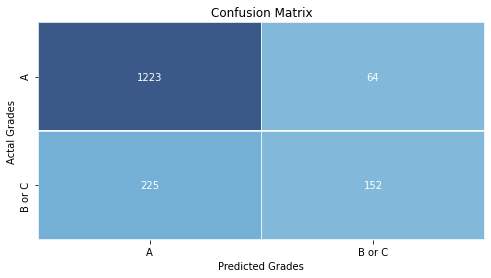

In [171]:
import matplotlib as mpl

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.8)
plt.title('Confusion Matrix')
plt.ylabel('Actal Grades')
plt.xlabel('Predicted Grades')
plt.show()

In [174]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, stratify=y)

# SMOTE training data only
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not majority')
X_smote, y_smote = smote.fit_sample(X_train_smote, y_train_smote)

# Fit on training data
rf_smote = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=25,
    min_samples_leaf=3, 
    max_features='auto',
    max_depth=25
)
# rf = BalancedRandomForestClassifier(n_estimators=1000)
rf_smote.fit(X_smote, y_smote)

# Predict on testing data
y_pred_smote = rf_smote.predict(X_test_smote)

# Evaluate Results
cr_smote = classification_report(y_test_smote, y_pred_smote)
print(cr_smote)


              precision    recall  f1-score   support

           A       0.90      0.86      0.88      1287
      B or C       0.59      0.69      0.64       377

    accuracy                           0.82      1664
   macro avg       0.75      0.77      0.76      1664
weighted avg       0.83      0.82      0.83      1664



In [12]:
# n_estimators = [100]
# max_features = ['auto','sqrt','log2']
# max_depth = [10, 50, np.nan]
# min_samples_split = [2, 20]
# min_samples_leaf = [2,25,50]

# grid_param = {
#     'n_estimators':n_estimators,
#     'max_features':max_features,
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'min_samples_leaf':min_samples_leaf
# }

# from sklearn.model_selection import RandomizedSearchCV
# rf_grid = RandomizedSearchCV(
#     estimator=RandomForestClassifier(),
#     param_distributions=grid_param,
#     n_iter=10,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
# rf_grid.fit(X, y)
# print(rf_grid.best_params_)
# print(rf_grid.best_score_)


In [431]:
# n_estimators = [500, 1000, 2500]
# max_features = ['auto','sqrt','log2']
# max_depth = [10, 35, 50, np.nan]
# min_samples_split = [2, 10, 20]
# min_samples_leaf = [1,2,10,25,50]

# Xx, yy = smote.fit_sample(X, y)
# rf_grid = RandomizedSearchCV(
#     estimator=rf_smote,
#     param_distributions=grid_param,
#     n_iter=50,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
# rf_grid.fit(Xx, yy)
# print(rf_grid.best_params_)
# print(rf_grid.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 5000, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}
0.8241393046431013


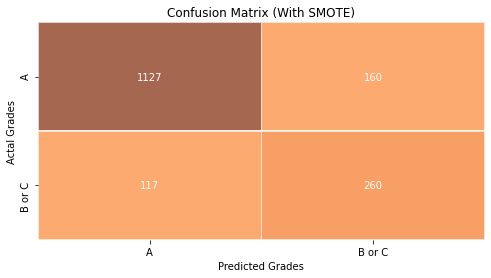

In [173]:
import matplotlib as mpl

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test_smote, y_pred_smote)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Oranges(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.7)
plt.title('Confusion Matrix (With SMOTE)')
plt.ylabel('Actal Grades')
plt.xlabel('Predicted Grades')
plt.show()

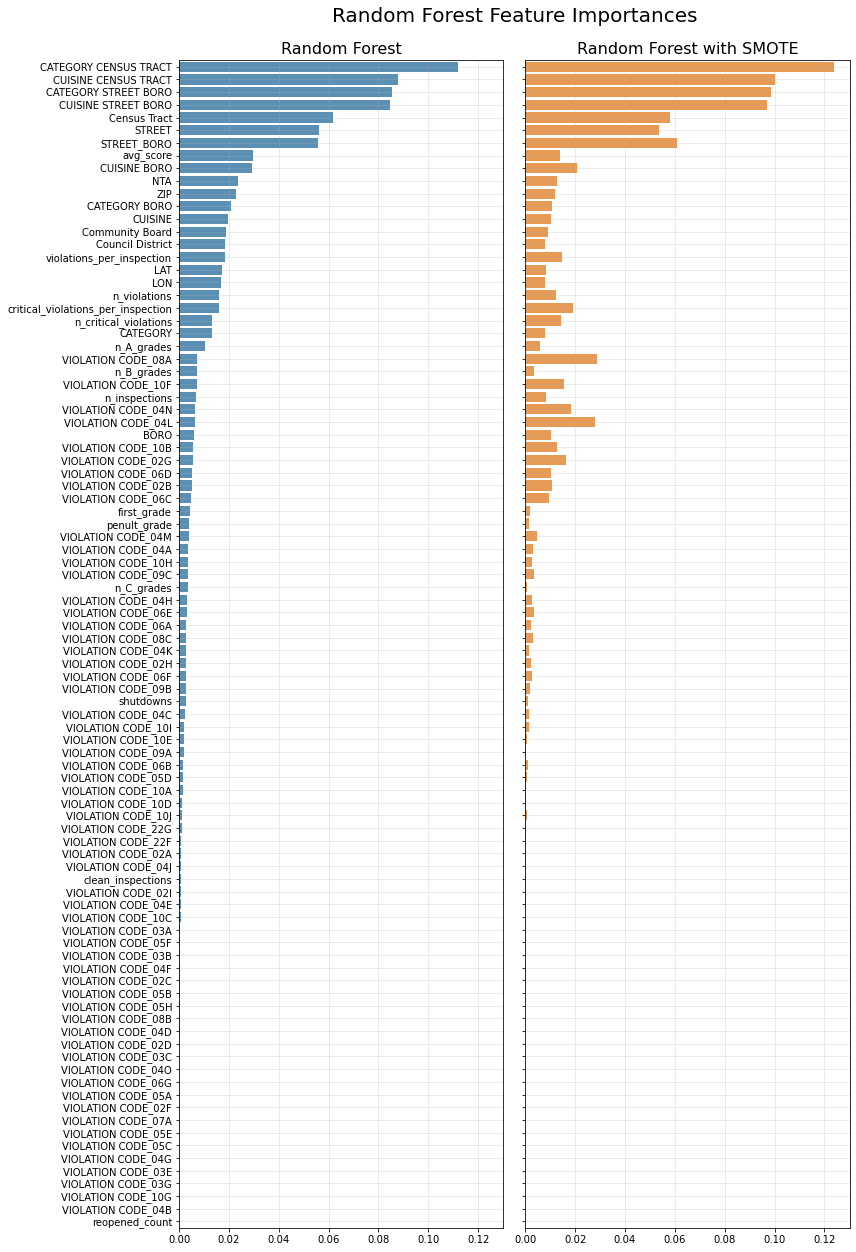

In [144]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,17), sharex=True)
importances_rf = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values()
importances_rf_smote = pd.Series(rf_smote.feature_importances_, index=X_test_smote.columns).sort_values()
sns.barplot(
    data=importances_rf.reset_index().sort_values(by=0, ascending=False),
    x=0,
    y='index',
    ax=ax[0],
    color='tab:blue',
    alpha=0.8
)
sns.barplot(
    data=importances_rf_smote[importances_rf.sort_values(ascending=False).index].reset_index(),
    x=0,
    y='index',
    ax=ax[1],
    color='tab:orange',
    alpha=0.8
)
ax[0].set_title('Random Forest', fontsize=16)
ax[1].set_title('Random Forest with SMOTE', fontsize=16)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].set_yticklabels(['']*len([item.get_text() for item in ax[1].get_yticklabels()]))
plt.tight_layout()
plt.suptitle('Random Forest Feature Importances', y=1.02, x=0.6, fontsize=20)
plt.show()


Text(0.5, 1.0, 'ROC Curve: Random Forest Predicting B or C Inspection Grades')

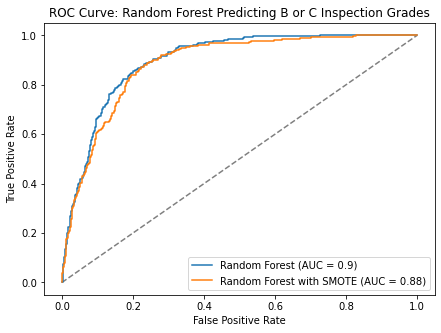

In [167]:
y_pred_prob_sm = rf_smote.predict_proba(X_test_smote)[:,1]
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test_smote, y_pred_prob_sm, pos_label='B or C')
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='B or C')
fig, ax = plt.subplots(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.plot(fpr, tpr, label='Random Forest (AUC = ' + str(round(roc_auc_score(y_test, y_pred_prob),2)) + ')')
plt.plot(fpr_sm, tpr_sm, label='Random Forest with SMOTE (AUC = ' + str(round(roc_auc_score(y_test_smote, y_pred_prob_sm),2)) + ')')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Predicting B or C Inspection Grades')